# House Prices - Advanced Regression Techniques

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
# from IPython.core.display import display, HTML
from IPython.display import display, HTML

display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import auc, mean_squared_error, mean_squared_log_error, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, label_binarize
from sklearn.ensemble     import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree         import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.impute       import SimpleImputer
# ---- 추가 모델
from sklearn.ensemble     import AdaBoostRegressor, VotingRegressor
from xgboost              import XGBRegressor
from lightgbm             import LGBMRegressor
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from pandas_profiling import ProfileReport


# DATA LOAD

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

<img src='./lot구조.png'>

- 컬럼명 ref : https://mazdah.tistory.com/883
- Lot : 사유지

MSSubClass: 주거유형 Identifies the type of dwelling involved in the sale.

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: 건물형태 Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
	
LotFrontage: 주택에 연결된 거리의 직선 피트Linear feet of street connected to property

LotArea: 대지 면적Lot size in square feet

Street: 도로 (포장/ 비포장) Type of road access to property

       Grvl	Gravel -> 비포장
       Pave	Paved -> 포장
       	
Alley: 골목 Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
		
LotShape: 택지의 모양 General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
       
LandContour: 등고선 Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression
		
Utilities: 수도, 가스, 전기 시설 가능 여부Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only	
	
LotConfig: 택지 구성 Lot configuration

       Inside	Inside lot : 내부구조
       Corner	Corner lot : 코너에 위치
       CulDSac	Cul-de-sac : 막다른 길
       FR2	Frontage on 2 sides of property 
       FR3	Frontage on 3 sides of property
	
LandSlope: 경사도 Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope
	
Neighborhood: 미국 물리적 주소위치(인접도시) Physical locations within Ames city limits

    Bloomington Heights 일리노이
    Bluestem
    Briardale 브라이어데일 그린스 골프 코스
    Brookside 컨트리 클럽 플라자 근방
    Clear Creek 콜로라도의 카운티
    College Creek 칼리지 강
    Crawford 미국 조지아 주 오글 소프 카운티에있는 도시(2010년 인구조사 832명)
    Edwards 캘리포니아주 모하비 사막에 있는 공군 기지
    Gilbert 애리조나 주의 도시
    Iowa DOT and Rail Road 아이오와주 교통부
    Meadow Village 텍사스 샌안토니오 지역
    Mitchell 사우스다코타 주
    North Ames 에임스 - 아이오와의 도시(대학도시)
    Northridge 캘리포니아 로스앤젤레스의 지역
    Northpark Villa 워싱턴 시애틀의 아파트
    Northridge Heights 네브래스카 링컨의 아파트 단지
    Northwest Ames 에임스 - 아이오와의 도시(대학도시)
    Old Town 캘리포니아 샌디에고의 지역
    South & West of Iowa State University 아이오와 주립대학의 남서부
    Sawyer 위스콘신의 카운티 (이 지역의 총 인구 수는 16,489명)
    Sawyer West 위스콘신의 카운티 서쪽
    Somerset 미국 매사추세츠 주 브리스톨 카운티의 마을
    Stone Brook 뉴욕 주립대
    Timberland 포틀랜드
    Veenker 아이오와 에임스의 대중 골프장

            
Condition1: 조건들과의 근접성 Proximity to various conditions

    Artery : Adjacent to arterial street (간선가로에 인접)
    Feedr : Adjacent to feeder street (진입로에 인접)
    Norm : Normal
    RRNn : Within 200' of North-South Railroad (남북 철도에서 200내에)
    RRAn : Adjacent to North-South Railroad (남북 철도에 인접)
    PosN : Near positive off-site feature--park, greenbelt, etc. (공원, 그린벨트 등 가까이에 있는 긍정적 외부 장소)
    PosA : Adjacent to postive off-site feature
    RRNe : Within 200' of East-West Railroad (동서 철도에 200내에)
    RRAe : Adjacent to East-West Railroad (동서 철도에 인접)

Condition2: 다양한 조건들과의 근접성 ( 조건 둘 이상 ) Proximity to various conditions (if more than one is present)
    Condition1에서 추가적으로 있는 인접 시설 
        Artery	Adjacent to arterial street
        Feedr	Adjacent to feeder street	
        Norm	Normal	
        RRNn	Within 200' of North-South Railroad
        RRAn	Adjacent to North-South Railroad
        PosN	Near positive off-site feature--park, greenbelt, etc.
        PosA	Adjacent to postive off-site feature
        RRNe	Within 200' of East-West Railroad
        RRAe	Adjacent to East-West Railroad
	
BldgType: 주거유형 Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
	
HouseStyle: Style of dwelling
    1Story : 1층집
    1.5Fin : 1.5층집: 2nd level finished
    1.5Unf : 1.5층집: 2nd level unfinished
    2Story : 2층집
    2.5Fin : 2.5층집 :2nd level finished
    2.5Unf : 2.5층집: 2nd level unfinished
    SFoyer : split foyer
    SLvl : split level
	
OverallQual: 집의 전체적인 재료 및 마감재 평가 Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
	
OverallCond: 집의 전반적인 상태평가 Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor
		
YearBuilt: 건물 지은 연도 Original construction date

YearRemodAdd: 리모델링 한 연도 Remodel date (same as construction date if no remodeling or additions)

RoofStyle: 지붕 스타일 Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed
		
RoofMatl: 지붕 재료 Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles
		
Exterior1st: 건물 외장 형태 1 Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	
Exterior2nd: 건물 외장 형태 2Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
       
MasVnrType: 평방미터 안의 벽돌 베니어 타입 Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
MasVnrArea: 평방미터 안의 벽돌 베니어 영역 Masonry veneer area in square feet

    - BrkCmn	Brick Common(갈색 벽돌)
    - BrkFace	Brick Face(얼굴모양 벽돌)
    - Stone	Stone(돌)

ExterQual: 외부 소재 품질 평가 Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
ExterCond: 외부 상태 Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
Foundation: 건축 틀 Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood
		
BsmtQual: 지하실 높이 평가 Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: 지하실 높이 평가 Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: 지하실에서 밖으로 나가는 문이 있는지 혹은 벽 높이가 정원 수준인지 Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: 지하실 완공 면적의 등급 Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: 크기가 1 평방 미터인 지하실 Type 1 finished square feet

BsmtFinType2: multiple type일 경우의 지하실 완공 면적 등급 Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: 크기가 2 평방 미터인 지하실 Type 2 finished square feet

BsmtUnfSF: 면적이 평방 미터로 측정이 안되는 지하실 Unfinished square feet of basement area

TotalBsmtSF: 지하실의 총 평방 미터 Total square feet of basement area

Heating: 난방 종류Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace
		
HeatingQC: 난방 상태 Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
		
CentralAir: 중앙 난방? Central air conditioning

       N	No
       Y	Yes
		
Electrical: 전기 시스템 Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
		
1stFlrSF: 1층의 평방피트 First Floor square feet
 
2ndFlrSF: 2층의 평방 피트 Second floor square feet

LowQualFinSF: Low quality finished square feet (all floors)

GrLivArea: 생활공간의 면적Above grade (ground) living area square feet

BsmtFullBath: full 욕실(세면대,변기, 샤워, 욕조)이 있는 지하실 Basement full bathrooms

BsmtHalfBath: half 욕실(세면대,변기)이 있는 지하실 Basement half bathrooms

FullBath: 지상층의 (모든 시설이 갖춰진)욕실 수 Full bathrooms above grade

HalfBath: 지상층의 (샤워시설 및 욕조가 없는)욕실 수 Half baths above grade

Bedroom: 지상층의 침실 수 (지하실의 침실은 제외) Bedrooms above grade (does NOT include basement bedrooms)

Kitchen: 지상층의 주방 수 Kitchens above grade

KitchenQual: 주방의 품질 Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       	
TotRmsAbvGrd: 지상층의 전체 방 수 (욕실 제외) Total rooms above grade (does not include bathrooms)

Functional: 집의 기능성 (공제가 보장되지 않는 경우 일반으로 가정) - 집이 제구실을 하는지? Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
		
Fireplaces: 벽난로 개수 Number of fireplaces

FireplaceQu: 벽난로 품질 Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
		
GarageType: 차고위치 Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
GarageYrBlt: 차고건설 연도 Year garage was built
		
GarageFinish: 차고 인테리어 마감 Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
		
GarageCars: 주차 가능 대수 기준 차고 크기 Size of garage in car capacity

GarageArea: 차고 면적(평방피트)Size of garage in square feet

GarageQual: 차고 품질 Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: 차고 상태 Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
PavedDrive: 진입로 포장 상태 Paved driveway

       Y	Paved (포장)
       P	Partial Pavement (부분 포장)
       N	Dirt/Gravel (비포장)
		
WoodDeckSF: 나무 바닥 면적 (평방피트) Wood deck area in square feet

OpenPorchSF: 개방된 베란다 면적 (평방피트) Open porch area in square feet

EnclosedPorch: 막힌 베란다 면적 (평방피트) Enclosed porch area in square feet

3SsnPorch: 3계절 베란다 면적 (평방피트) Three season porch area in square feet

ScreenPorch:  유리벽 베란다 면적 (평방피트) Screen porch area in square feet

PoolArea: 수영장 면적 (평방피트) Pool area in square feet

PoolQC: 수영장 품질 Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
		
Fence: 울타리 품질 Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
	
MiscFeature: 다른 카테고리에서 다루지 않은 기타 기능 Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None
		
MiscVal: 기타 기능의 가치 $Value of miscellaneous feature

MoSold: 집이 팔린 월 Month Sold (MM)

YrSold: 집이 팔린 연도 Year Sold (YYYY)

SaleType: 팔린유형 Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
		
SaleCondition: 판매 상태 Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members 
       Partial	Home was not completed when last assessed (associated with New Homes)


- 쉬운 버전
<pre>
- 1. train.csv : 학습 데이터
id : 데이터 고유 id
OverallQual : 전반적 재료와 마감 품질
YearBuilt : 완공 연도
YearRemodAdd : 리모델링 연도
ExterQual : 외관 재료 품질
BsmtQual : 지하실 높이
TotalBsmtSF : 지하실 면적 
1stFlrSF : 1층 면적 
GrLivArea : 지상층 생활 면적
FullBath : 지상층 화장실 개수 
KitchenQual : 부억 품질 
GarageYrBlt : 차고 완공 연도
GarageCars: 차고 자리 개수
GarageArea: 차고 면적 
target : 집값(달러 단위)


- 2.test.csv
id : 데이터 고유 id
OverallQual : 전반적 재료와 마감 품질
YearBuilt : 완공 연도
YearRemodAdd : 리모델링 연도
ExterQual : 외관 재료 품질
BsmtQual : 지하실 높이
TotalBsmtSF : 지하실 면적 
1stFlrSF : 1층 면적 
GrLivArea : 지상층 생활 면적
FullBath : 지상층 화장실 개수 
KitchenQual : 부억 품질 
GarageYrBlt : 차고 완공 연도
GarageCars: 차고 자리 개수
GarageArea: 차고 면적

## 고유값 제거 : ID 

In [6]:
train= train.drop('Id', axis = 1)
test= test.drop('Id', axis = 1)

## 결측 확인

In [7]:
train.isna().sum()[train.isna().sum()>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [8]:
test.isna().sum()[test.isna().sum()>0]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

### LotFrontage
- 집에서 도로까지의 직선 거리 
- 결측 (259건) 0으로 채움

In [9]:
train['LotFrontage'].isna().sum()

259

In [10]:
train['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [11]:
train['LotFrontage'].fillna(0,inplace=True)

#### test

In [12]:
test['LotFrontage'].isna().sum()

227

In [13]:
test['LotFrontage'] = test['LotFrontage'].fillna(0)

### (▼Alley), Street(다중 공선 둘중 하나)  
- Alley : 집에 접근하는 골목의 형태
    null                   ->0
    Grvl    : 50(비포장)   ->0
    Pave    : 41(포장)     ->1
    
- Street : 집까지 이어지는 길의 형태
    null    ->0
    Grvl    ->0
    Pave    ->1

In [14]:
train[train['Alley'].notna()][:2]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
21,45,RM,57.0,7449,Pave,Grvl,Reg,Bnk,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1.5Unf,7,7,1930,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,637,637,GasA,Ex,Y,FuseF,1108,0,0,1108,0,0,1,0,3,1,Gd,6,Typ,1,Gd,Attchd,1930.0,Unf,1,280,TA,TA,N,0,0,205,0,0,0,NaN,GdPrv,NaN,0,6,2007,WD,Normal,139400
30,70,C (all),50.0,8500,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Feedr,Norm,1Fam,2Story,4,4,1920,1950,Gambrel,CompShg,BrkFace,BrkFace,None,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0,Unf,0,649,649,GasA,TA,N,SBrkr,649,668,0,1317,0,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1920.0,Unf,1,250,TA,Fa,N,0,54,172,0,0,0,NaN,MnPrv,NaN,0,7,2008,WD,Normal,40000


In [15]:
train['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [16]:
train['Alley'] = train['Alley'].replace(['Grvl','Pave'],[0,1])
train['Alley'].fillna(0,inplace=True)

train['Street'] = train['Street'].replace(['Grvl','Pave'],[0,1])
train['Street'].fillna(0,inplace=True)

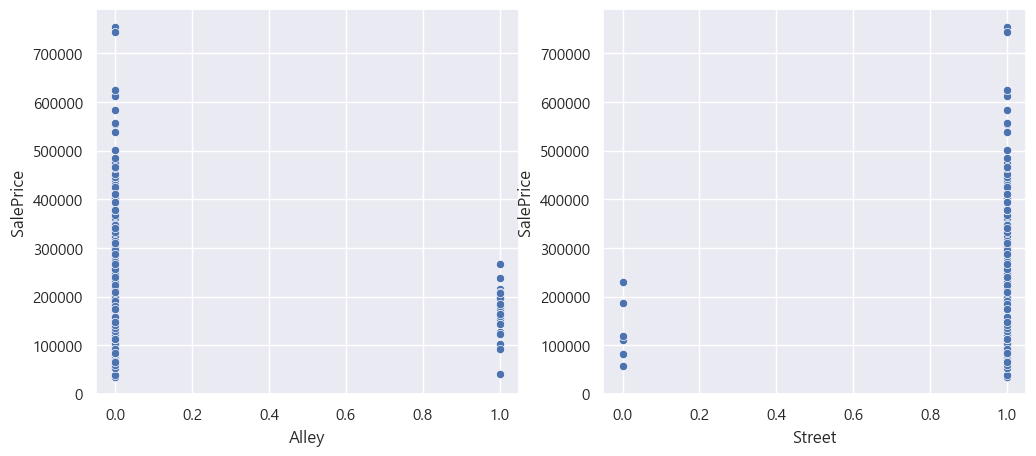

In [17]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = train['Alley'], y=train['SalePrice'],ax=ax[0])
sns.scatterplot(x = train['Street'], y=train['SalePrice'],ax=ax[1])
plt.show()

In [18]:
train = train.drop('Alley',axis=1)

#### test

In [19]:
test['Alley'] = test['Alley'].replace(['Grvl','Pave'],[0,1])
test['Alley'].fillna(0,inplace=True)

test['Street'] = test['Street'].replace(['Grvl','Pave'],[0,1])
test['Street'].fillna(0,inplace=True)

In [20]:
test = test.drop('Alley',axis=1)

### MasVnrType 
- 평방미터 안의 벽돌 베니어 영역
- BrkCmn	Brick Common(갈색 벽돌)
- BrkFace	Brick Face(얼굴모양 벽돌)
- Stone	Stone
- 결측치를 None으로 채움

In [21]:
train['MasVnrType'].isna().sum()[train['MasVnrType'].isna().sum()>0]

array([8], dtype=int64)

In [22]:
train['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [23]:
train['MasVnrType'].mode()[0]

'None'

In [24]:
train["MasVnrType"] = train["MasVnrType"].fillna(train['MasVnrType'].mode()[0])

#### test

In [25]:
test['MasVnrType'].isna().sum()

16

In [26]:
test['MasVnrType'].value_counts()

None       878
BrkFace    434
Stone      121
BrkCmn      10
Name: MasVnrType, dtype: int64

In [27]:
test["MasVnrType"] = test["MasVnrType"].fillna(test['MasVnrType'].mode()[0])

### MasVnrArea
- 벽돌 베니어 영역
- 결측치는 0으로 채움

In [28]:
train[train['MasVnrArea'].isna()].shape

(8, 79)

In [29]:
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)

### BsmtQual , BsmtCond    : 37개 결측 -> 0처리
- BsmtQual : 지하실 높이
    Ex  Excellent (100+ inches)  -> 5
    Gd	Good (90-99 inches)      -> 4
    TA	Typical (80-89 inches)   -> 3
    Fa	Fair (70-79 inches)      -> 2
    Po	Poor (<70 inches         -> 1
    NA	No Basement              -> 0

- BsmtCond: 지하실 상태평가
    Ex	Excellent   ->5
    Gd	Good        -> 4
    TA	Typical - slight dampness allowed     ->3
    Fa	Fair - dampness or some cracking or settling    -> 2
    Po	Poor - Severe cracking, settling, or wetness    -> 1
    NA	No Basement                                     -> 0

In [30]:
train['BsmtQual'].value_counts()

TA    649
Gd    618
Ex    121
Fa     35
Name: BsmtQual, dtype: int64

In [31]:
train['BsmtCond'].value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64

In [32]:
train['BsmtCond'].isna().sum()

37

In [33]:
train[(train['BsmtCond'].isna())&(train['BsmtQual'].isna())].shape

(37, 79)

In [34]:
val_dic={'Ex':5, 'Gd':4 ,'TA':3,'Fa':2,'Po':1,'NA':0}
train['BsmtQual']=train['BsmtQual'].replace(val_dic)
train['BsmtCond']=train['BsmtCond'].replace(val_dic)
train['BsmtQual'] = train['BsmtQual'].fillna(0)
train['BsmtCond'] = train['BsmtCond'].fillna(0)

#### test

In [35]:
test[['BsmtQual','BsmtCond']].isna().sum()

BsmtQual    44
BsmtCond    45
dtype: int64

In [36]:
val_dic={'Ex':5, 'Gd':4 ,'TA':3,'Fa':2,'Po':1,'NA':0}
test['BsmtQual']=test['BsmtQual'].replace(val_dic)
test['BsmtCond']=test['BsmtCond'].replace(val_dic)
test[['BsmtQual','BsmtCond']] = test[['BsmtQual','BsmtCond']].fillna(0)

### BsmtExposure
- 지하실에서 밖으로 나가는 문이 있는지 혹은 벽 높이가 정원 수준인지

       Gd	Good Exposure  ->4
       Av	Average Exposure (split levels or foyers typically score average or above)  ->3
       Mn	Mimimum Exposure  ->2
       No	No Exposure  -> 1   (1개)
       NA	No Basement  -> 0  (37개)

In [37]:
train[(train['BsmtExposure'].isna())&(train['BsmtQual']==0)].shape  # -> Na 

(37, 79)

In [38]:
train['BsmtExposure'].isna().sum()

38

In [39]:
train[(train['BsmtExposure'].isna())&(train['BsmtQual']!=0)].index[0] # -> 최빈값(No로 채워줌)

948

In [40]:
train.loc[948,'BsmtExposure']='No'

In [41]:
train['BsmtExposure'].value_counts()

No    954
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64

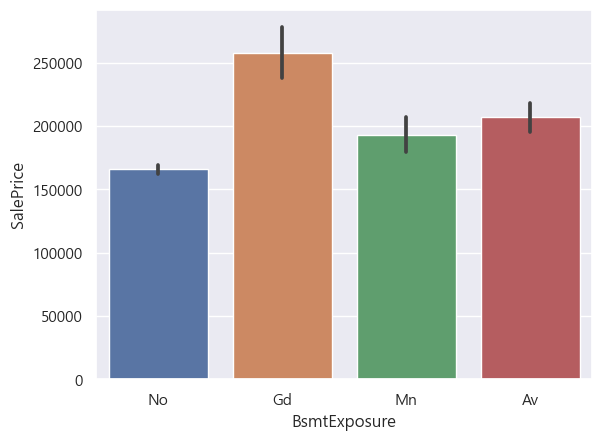

In [42]:
sns.barplot(x = train['BsmtExposure'], y=train['SalePrice'])
plt.show()

In [43]:
exposure_dic={'Gd':4 ,'Av':3 ,'Mn':2,'No':1} #  NA -> 0  (37개)
train['BsmtExposure'].replace(exposure_dic,inplace=True)
train['BsmtExposure'].fillna(0,inplace=True)

In [44]:
train['BsmtExposure'].value_counts()

1.0    954
3.0    221
4.0    134
2.0    114
0.0     37
Name: BsmtExposure, dtype: int64

In [45]:
train['BsmtExposure'].isna().sum()

0

#### test

In [46]:
test['BsmtExposure'].value_counts()

No    951
Av    197
Gd    142
Mn    125
Name: BsmtExposure, dtype: int64

In [47]:
exposure_dic={'Gd':4 ,'Av':3 ,'Mn':2,'No':1}
test['BsmtExposure'].replace(exposure_dic,inplace=True)
test['BsmtExposure'].fillna(0,inplace=True)

In [48]:
test['BsmtExposure'].isna().sum()

0

### BsmtFinType1
- 지하실 마감 등급
       GLQ	Good Living Quarters  6
       ALQ	Average Living Quarters   5
       BLQ	Below Average Living Quarters	    4
       Rec	Average Rec Room    3
       LwQ	Low Quality    2 
       Unf	Unfinshed     1
       NA	No Basement      0

In [49]:
train['BsmtFinType1'].value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64

In [50]:
train['BsmtFinType1'].isna().sum()

37

In [51]:
dic ={'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1}
train['BsmtFinType1'].replace(dic,inplace=True)
train['BsmtFinType1'].fillna(0,inplace = True)

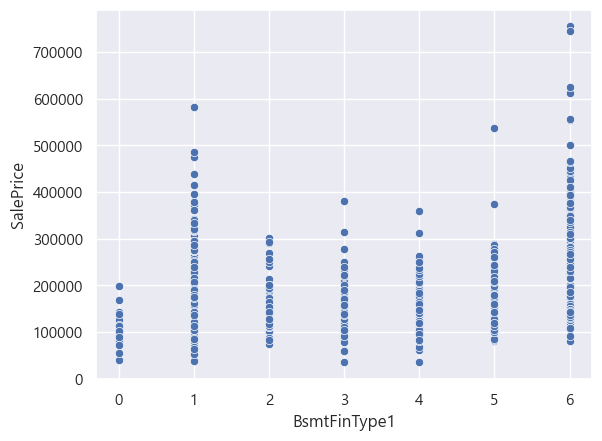

In [52]:
sns.scatterplot(x = train['BsmtFinType1'], y=train['SalePrice'])
plt.show()

#### test

In [53]:
test['BsmtFinType1'].isna().sum()

42

In [54]:
dic ={'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1}
test['BsmtFinType1'].replace(dic,inplace=True)
test['BsmtFinType1'].fillna(0,inplace = True)

### BsmtFinType2
- 지하실 마감등급 다중
       GLQ	Good Living Quarters  6
       ALQ	Average Living Quarters   5
       BLQ	Below Average Living Quarters	    4
       Rec	Average Rec Room    3
       LwQ	Low Quality    2 
       Unf	Unfinshed     1
       NA	No Basement      0

In [55]:
train['BsmtFinType2'].value_counts()

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64

In [56]:
train['BsmtFinType2'].isna().sum()

38

In [57]:
train[(train['BsmtFinType2'].isna())&(train['BsmtFinType1']!=0)]  
# 지하실 BsmtFinType1는 있고 2는 없음(즉 마감이 하나) -> 0처리

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
332,20,RL,85.0,10655,1,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,8,5,2003,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,296.0,Gd,TA,PConc,4.0,3.0,1.0,6.0,1124,NaN,479,1603,3206,GasA,Ex,Y,SBrkr,1629,0,0,1629,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2003.0,RFn,3,880,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,284000


In [58]:
dic ={'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1}
train['BsmtFinType2'].replace(dic,inplace=True)
train['BsmtFinType2'].fillna(0,inplace = True)

#### test

In [59]:
test['BsmtFinType2'].value_counts()

Unf    1237
Rec      51
LwQ      41
BLQ      35
ALQ      33
GLQ      20
Name: BsmtFinType2, dtype: int64

In [60]:
test['BsmtFinType2'].isna().sum()

42

In [61]:
dic ={'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1}
test['BsmtFinType2'].replace(dic,inplace=True)
test['BsmtFinType2'].fillna(0,inplace = True)

### Electrical
- 전기 시스템
    SBrkr	Standard Circuit Breakers & Romex
    FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
    FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
    FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
    Mix	Mixed


In [62]:
train['Electrical'].value_counts()

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

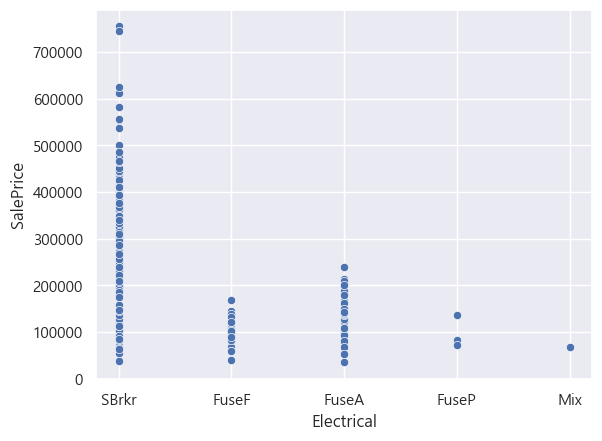

In [63]:
sns.scatterplot(x = train['Electrical'], y=train['SalePrice'])
plt.show()

In [64]:
train[train['Electrical'].isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,80,RL,73.0,9735,1,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,4.0,3.0,1.0,1.0,0,1.0,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


In [65]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode().values[0])

In [66]:
train['Electrical'].isna().sum()

0

#### test

In [67]:
test['Electrical'].isna().sum()

0

### FireplaceQu
- 벽난로 상태
    Ex	Excellent - Exceptional Masonry Fireplace   ->5
    Gd	Good - Masonry Fireplace in main level      ->4
    TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement   ->3
    Fa	Fair - Prefabricated Fireplace in basement     ->2
    Po	Poor - Ben Franklin Stove                      ->1
    NA	No Fireplace                                   ->0  

In [68]:
train['FireplaceQu'].isna().sum()

690

In [69]:
train['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [70]:
val_dic={'Ex':5, 'Gd':4 ,'TA':3,'Fa':2,'Po':1}
train['FireplaceQu'].replace(val_dic,inplace=True)
train['FireplaceQu'].fillna(0,inplace=True)

#### test

In [71]:
test['FireplaceQu'].isna().sum()

730

In [72]:
test['FireplaceQu'].value_counts()

Gd    364
TA    279
Fa     41
Po     26
Ex     19
Name: FireplaceQu, dtype: int64

In [73]:
val_dic={'Ex':5, 'Gd':4 ,'TA':3,'Fa':2,'Po':1}
test['FireplaceQu'].replace(val_dic,inplace=True)
test['FireplaceQu'].fillna(0,inplace=True)

### Garage
<pre>
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81

-> 81건은 차고가 없음

#### ★파생피쳐: 차고지 유무
- 'garage_yn' : 0 없음, 1있음

In [74]:
train['garage_yn']=np.where(train['GarageYrBlt'].isna(),0,1)
train[train['garage_yn']==0].shape

(81, 80)

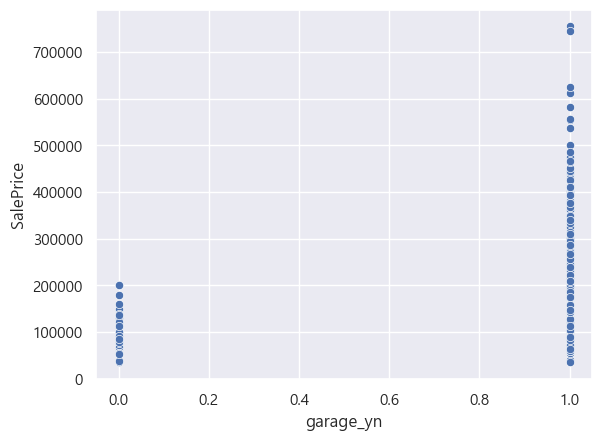

In [75]:
sns.scatterplot(x = train['garage_yn'], y=train['SalePrice'])
plt.show()

##### test

In [76]:
test['garage_yn']=np.where(test['GarageYrBlt'].isna(),0,1)
test[test['garage_yn']==0].shape

(78, 79)

#### GarageType
       2Types	More than one type of garage         ->6
       Attchd	Attached to home         ->5
       Basment	Basement Garage    ->4
       BuiltIn	Built-In (Garage part of house - typically has room above garage)   ->3
       CarPort	Car Port    ->2
       Detchd	Detached from home   ->1
       NA	No Garage   -> 0

In [77]:
train[(train['GarageType'].isna())|(train['GarageYrBlt'].isna())].shape

(81, 80)

In [78]:
train['GarageType'].value_counts()

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

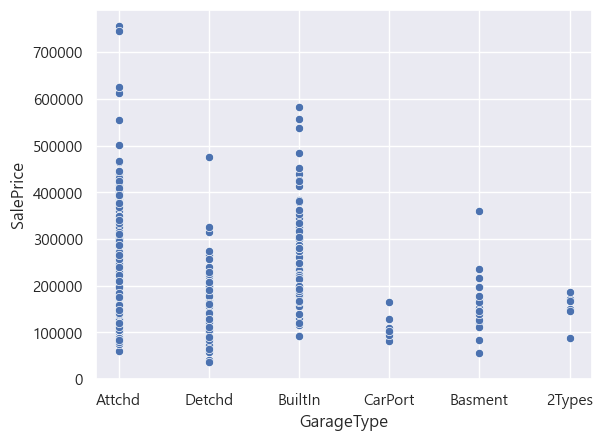

In [79]:
sns.scatterplot(x = train['GarageType'], y=train['SalePrice'])
plt.show()

In [80]:
dic_garage = {'2Types':6, 'Attchd':5, 'Basment':4 ,'BuiltIn':3,'CarPort':2,'Detchd':1}
train['GarageType'].replace(dic_garage,inplace=True)
train['GarageType'].fillna(0,inplace=True)

In [81]:
train['GarageType'].isna().sum()

0

##### test

In [82]:
dic_garage = {'2Types':6, 'Attchd':5, 'Basment':4 ,'BuiltIn':3,'CarPort':2,'Detchd':1}
test['GarageType'].replace(dic_garage,inplace=True)
test['GarageType'].fillna(0,inplace=True)

#### ▼GarageYrBlt
- 결측은 차고가 없음 ->YearBuilt(시공일)으로 채움
- 중요치 않아 보임 (drop 예정)

In [83]:
train['GarageYrBlt'].isna().sum()

81

In [84]:
train[train['GarageYrBlt']==train['YearBuilt']].shape

(1089, 80)

In [85]:
train[train['GarageYrBlt']==train['YearBuilt']].shape

(1089, 80)

In [86]:
train['GarageYrBlt'].fillna(train['YearBuilt'],inplace=True)

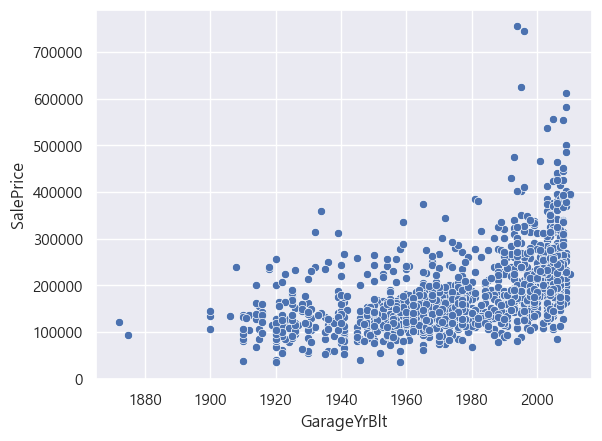

In [87]:
sns.scatterplot(x = train['GarageYrBlt'], y=train['SalePrice'])
plt.show()

##### test

In [88]:
test['GarageYrBlt'].isna().sum()

78

In [89]:
test['GarageYrBlt'].fillna(test['YearBuilt'],inplace=True)

In [90]:
train=train.drop('GarageYrBlt',axis=1)
test=test.drop('GarageYrBlt',axis=1)

#### GarageFinish

       Fin	Finished  ->3
       RFn	Rough Finished   ->2
       Unf	Unfinished   ->1
       NA	No Garage    ->0

In [91]:
gar_fin_dic = {'Fin': 3, 'RFn': 2,'Unf':1}
train['GarageFinish'].replace(gar_fin_dic,inplace=True)
train['GarageFinish'].fillna(0,inplace=True)

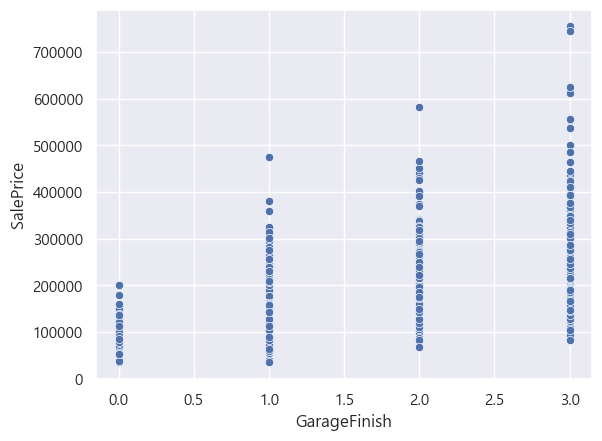

In [92]:
sns.scatterplot(x = train['GarageFinish'], y=train['SalePrice'])
plt.show()

##### test

In [93]:
gar_fin_dic = {'Fin': 3, 'RFn': 2,'Unf':1}
test['GarageFinish'].replace(gar_fin_dic,inplace=True)
test['GarageFinish'].fillna(0,inplace=True)

#### ▼GarageQual, GarageCond -> ★파생피쳐 garageall      
- 차고 상태와 퀄리티는 'TA' -> 적당한게 좋다
- drop 하고 파생 피쳐 만들어서 하나로 합침

In [94]:
val_dic={'Ex':5, 'Gd':4 ,'TA':3,'Fa':2,'Po':1}

In [95]:
train['GarageQual'].value_counts()

TA    1311
Fa      48
Gd      14
Ex       3
Po       3
Name: GarageQual, dtype: int64

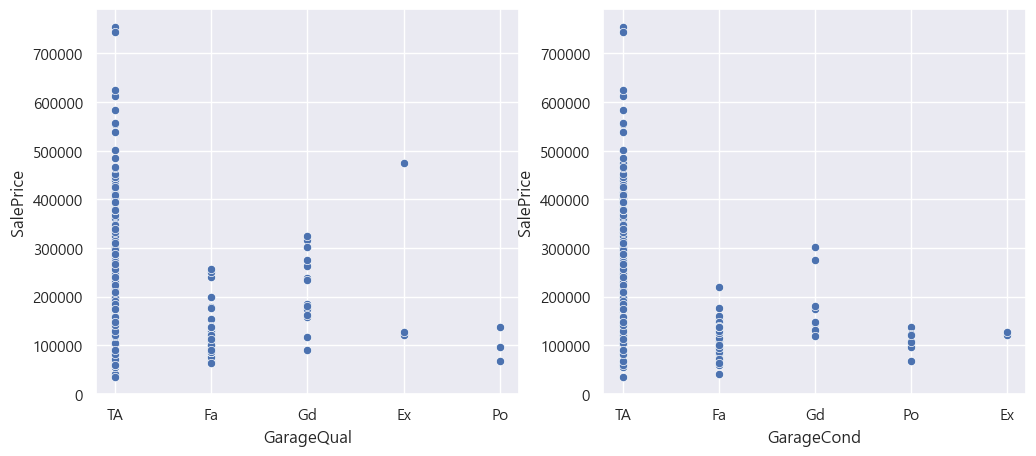

In [96]:
fig,ax=plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(x = train['GarageQual'], y=train['SalePrice'],ax=ax[0])

sns.scatterplot(x = train['GarageCond'], y=train['SalePrice'],ax=ax[1])
plt.show()

In [97]:
train[train['GarageQual']=='TA'].shape

(1311, 79)

In [98]:
train[train['GarageCond']=='TA'].shape

(1326, 79)

In [99]:
train[(train['GarageQual']=='TA')|(train['GarageCond']=='TA')].shape

(1346, 79)

In [100]:
train['garageall']=np.where((train['GarageQual']=='TA')|(train['GarageCond']=='TA'),1,0)

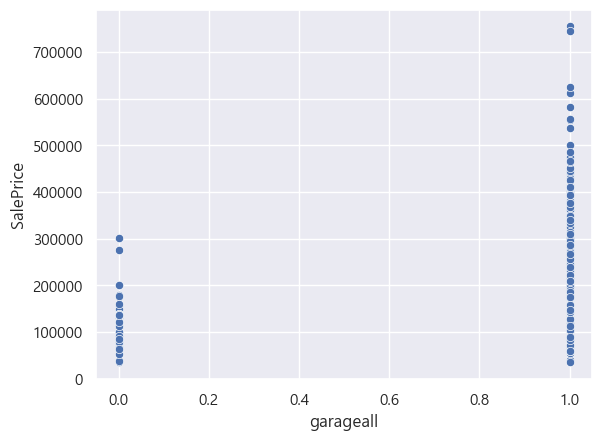

In [101]:
sns.scatterplot(x = train['garageall'], y=train['SalePrice'])
plt.show()

In [102]:
train = train.drop(['GarageQual', 'GarageCond'],axis=1)

##### test

In [103]:
test['garageall']=np.where((test['GarageQual']=='TA')|(test['GarageCond']=='TA'),1,0)

In [104]:
test = test.drop(['GarageQual', 'GarageCond'],axis=1)

### ▼PoolQC , ▼PoolArea

In [105]:
train['PoolQC'].notna().sum()

7

In [106]:
train['PoolArea'][train['PoolArea']!=0].shape

(7,)

#### ★ 파생피쳐 pool_yn

In [107]:
train['pool_yn']= np.where(train['PoolQC'].notna(),1,0)
train.drop(['PoolQC','PoolArea'],axis=1,inplace=True)

In [108]:
train['pool_yn'].value_counts()

0    1453
1       7
Name: pool_yn, dtype: int64

##### test

In [109]:
test['pool_yn']= np.where(test['PoolQC'].notna(),1,0)
test.drop(['PoolQC','PoolArea'],axis=1,inplace=True)

In [110]:
test['pool_yn'].value_counts()

0    1456
1       3
Name: pool_yn, dtype: int64

### Fence
       GdPrv	Good Privacy    ->4
       MnPrv	Minimum Privacy   ->3
       GdWo	Good Wood            ->2
       MnWw	Minimum Wood/Wire    ->1
       NA	No Fence             ->0

In [111]:
train['Fence'].isna().sum()

1179

In [112]:
train['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

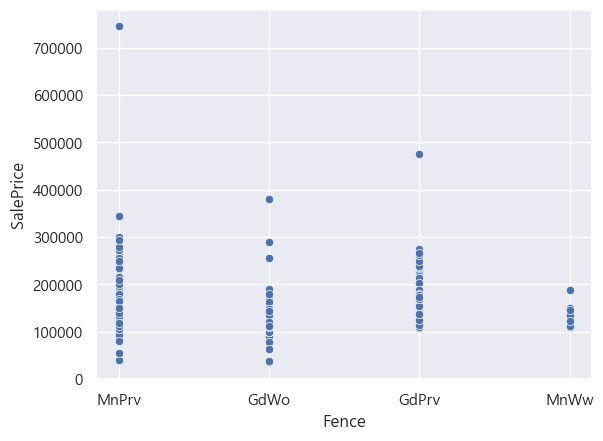

In [113]:
sns.scatterplot(x = train['Fence'], y=train['SalePrice'])
plt.show()

In [114]:
fen_dic={'GdPrv':4,'MnPrv':3, 'GdWo':2,'MnWw':1}  
train['Fence'].replace(fen_dic,inplace=True)
train['Fence'].fillna(0,inplace=True)

#### test

In [115]:
test['Fence'].isna().sum()

1169

In [116]:
fen_dic={'GdPrv':4,'MnPrv':3, 'GdWo':2,'MnWw':1}  
test['Fence'].replace(fen_dic,inplace=True)
test['Fence'].fillna(0,inplace=True)

### MiscFeature, MiscVal
- MiscFeature 
: 다른 카테고리에서 다루지 않은 기타 기능
    Elev	Elevator
    Gar2	2nd Garage (if not described in garage section)
    Othr	Other
    Shed	Shed (over 100 SF) 창고
    TenC	Tennis Court
    NA	None
  

- MiscVal
: 기타 기능의 가치


In [117]:
train['MiscFeature'].isna().sum()

1406

In [118]:
train[train['MiscVal']==0].shape[0]

1408

In [119]:
train['MiscFeature'][(train['MiscFeature'].notna())&(train['MiscVal']==0)]

873     Othr
1200    Shed
Name: MiscFeature, dtype: object

In [120]:
train['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [121]:
train['MiscVal'].value_counts()

0        1408
400        11
500         8
700         5
450         4
600         4
2000        4
1200        2
480         2
15500       1
800         1
350         1
3500        1
1300        1
54          1
620         1
560         1
1400        1
8300        1
1150        1
2500        1
Name: MiscVal, dtype: int64

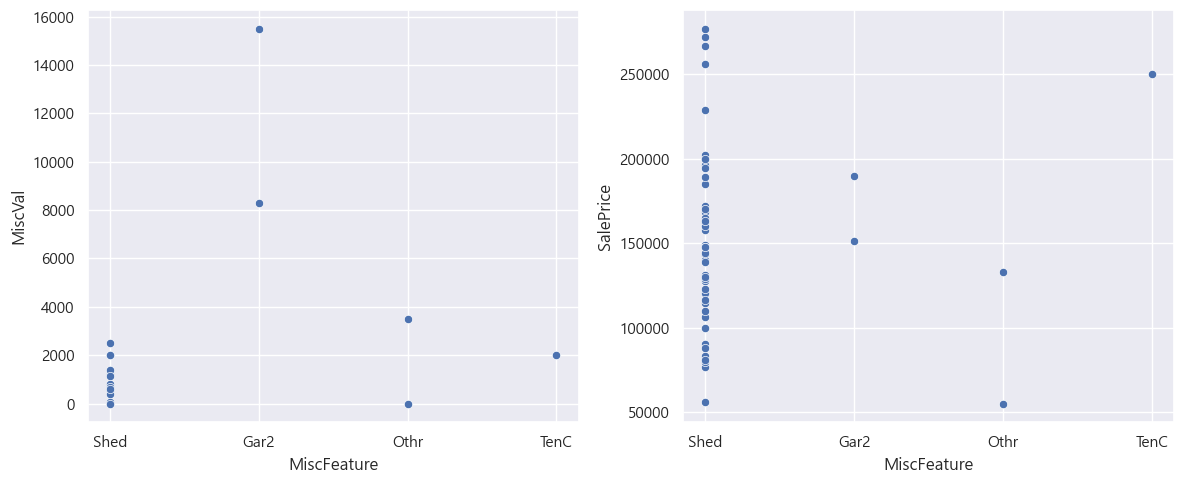

In [122]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = train['MiscFeature'], y=train['MiscVal'],ax=ax[0])
sns.scatterplot(x = train['MiscFeature'], y=train['SalePrice'],ax=ax[1])
plt.tight_layout()
plt.show()

# test 데이터 결측 확인하기

In [ ]:
ㅇㄹㄴㄹㄴㄹㅇㄹㄴㅇㄹㄴㅇㄹㄴㅇㄹ

## 컬럼 분류
<pre>
● 날짜 관련 
  - ['YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']
    
● 집 총평 
  - Overall 1 ~10  
  - Qual , QC, Qu, Cond {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}
  - ['OverallQual','OverallCond','KitchenQual','HeatingQC','FireplaceQu','ExterQual','ExterCond','BsmtQual','BsmtCond','GarageQual','GarageCond','PoolQC']     

● 판매 관련 
  - ['SaleType','SaleCondition','MSSubClass','MSZoning','BldgType','HouseStyle','Functional']
  - MSSubClass(판매유형), MSZoning(용도구분), BldgType(주거유형), HouseStyle(주거스타일), 홈기능(Functional)
              
● 전용면적 
  - ['GrLivArea','1stFlrSF','2ndFlrSF','LotArea','LandSlope','LandContour']
  - Lot*,  GrLivArea(1stFlrSF,2ndFlrSF,LotArea), LandSlope(기울기), LandContour(평평도)
              
● 내부시설(구조물갯수,난방)
  - ['TotRmsAbvGrd','Bedroom','FullBath','HalfBath','Kitchen','Utilities','Heating','HeatingQC','Fireplaces','CentralAir','Electrical']
    
● 외부시설
  - porch*, WoodDeckSF
  - 지하실 : Bsmt*  
  - 차고지: Garage*
  - 공사진행여부 ['LowQualFinSF','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF']
  - 기타자산 Pool, Mise ['PoolArea','PoolQC','MiscVal','MiscFeature'] 
            
● 외장재
  - Exter* , MasVnr*, FenseRoof

● 도로 
  - 포장 : Street, PavedDrive, Alley      
  - 접근성 : Condition1, Condition2, Neighborhood
</pre>

### Target : SalePrice

In [123]:
train['SalePrice'].nunique()

663

### 날짜 관련 
  - ['YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']
    

In [124]:
train['YearBuilt'].value_counts()[:5]

2006    67
2005    64
2004    54
2007    49
2003    45
Name: YearBuilt, dtype: int64

In [125]:
train['YearRemodAdd'].value_counts()[:5]

1950    178
2006     97
2007     76
2005     73
2004     62
Name: YearRemodAdd, dtype: int64

In [126]:
train['YearBuilt'][(train['YearBuilt']==train['GarageYrBlt'])].count()

KeyError: 'GarageYrBlt'

In [ ]:
train['YearBuilt'][(train['YearBuilt']!=train['GarageYrBlt'])&(train['GarageYrBlt']==train['YearRemodAdd'])].count()

train에서 차고지 건축 연도와 거주지 건축 연도가 같은 데이터 : 1089
train에서 차고지 건축 연도와 거주지 건축 연도가 다른 데이터 : 371 (리모델링 하면서 차고지를 지은 건수 : 54)

In [ ]:
train.shape

In [ ]:
train[['YrSold','MoSold']]

#### 차고지 생긴 연도와 팔린 연도 비교

In [ ]:
train['GarageYrBlt'][train['GarageYrBlt']<train['YrSold']].count()

In [ ]:
train['GarageYrBlt'][train['GarageYrBlt']>=train['YrSold']].count()

### 집 총평 
  - Overall 1 ~10  
  - Qual , QC, Qu, Cond {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}
  - ['OverallQual','OverallCond','KitchenQual','HeatingQC','FireplaceQu','ExterQual','ExterCond','BsmtQual','BsmtCond','GarageQual','GarageCond','PoolQC']     

### 판매 관련 
  - ['SaleType','SaleCondition','MSSubClass','MSZoning','BldgType','HouseStyle','Functional']
  - MSSubClass(판매유형), MSZoning(용도구분), BldgType(주거유형), HouseStyle(주거스타일), 홈기능(Functional)


### 전용면적 
  - ['GrLivArea','1stFlrSF','2ndFlrSF','LotArea','LandSlope','LandContour']
  - Lot*,  GrLivArea(1stFlrSF,2ndFlrSF,LotArea), LandSlope(기울기), LandContour(평평도)
            

### 내부시설(구조물갯수,난방)
  - ['TotRmsAbvGrd','Bedroom','FullBath','HalfBath','Kitchen','Utilities','Heating','HeatingQC','Fireplaces','CentralAir','Electrical']


### 외부시설
  - porch*, WoodDeckSF
  - 지하실 : Bsmt*  
  - 차고지: Garage*
  - 공사진행여부 ['LowQualFinSF','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF']
  - 기타자산 Pool, Mise ['PoolArea','PoolQC','MiscVal','MiscFeature'] 


### 외장재
  - Exter* , MasVnr*, FenseRoof

### 도로 
  - 포장 : Street, PavedDrive, Alley      
  - 접근성 : Condition1, Condition2, Neighborhood

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.head()

In [ ]:
# train = train[['OverallQual','YearBuilt','YearRemodAdd','ExterQual','BsmtQual','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath','KitchenQual','GarageYrBlt','GarageCars','GarageArea','SalePrice']]
# test = test[['OverallQual','YearBuilt','YearRemodAdd','ExterQual','BsmtQual','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath','KitchenQual','GarageYrBlt','GarageCars','GarageArea']]

In [ ]:
test.info(), train.info()

## EDA (pandas_profiling)

In [ ]:
# profile = ProfileReport(train, title='houseprice_mini')
# profile.to_file(output_file='houseprice_mini.html')

### Alerts

### 높은 상관도 
- OverallQual, YearBuilt
- YearRemodAdd, OverallQual
- GrLivArea, OverallQual
- GarageYrBlt, OverallQual
- GarageArea, OverallQual
- SalePrice,OverallQual
- ExterQual, OverallQual
- BsmtQual, OverallQual
- KitchenQual, OverallQual

- TotalBsmtSF, 1stFlrSF
- GarageCars ,GarageArea